# Learning rate test

In [1]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [2]:
DATA_DIR = os.path.abspath(os.path.join("data", "lrtest"))
%mkdir -p $DATA_DIR

# Test helpers

In [95]:
class SaveHistory(keras.callbacks.Callback):
    def __init__(self):
        self.batches = dict()
        self.epochs = dict()
        self.steps = list()
        self.train_ends = dict(batches=[], epochs=[])
        
    def _update(self, hist, logs={}):
        for k in self.params['metrics']:
            if k in logs:
                hist.setdefault(k, []).append(logs[k].item())
    
    def on_batch_end(self, batch, logs={}):
        self._update(self.batches, logs)
    
    def on_epoch_end(self, epoch, logs={}):
        self._update(self.epochs, logs)
        
    def on_train_end(self, logs={}):
        nbatches = len(self.batches.get('loss', []))
        self.train_ends['batches'].append(nbatches)
        
        nepochs = len(self.epochs.get('loss', []))
        self.train_ends['epochs'].append(nepochs)

In [96]:
class AssignAndSetVal(object):
    LABELS = ['assign', 'setval']
    
    @classmethod
    def set1(cls, model, value):
        model.optimizer.lr = value
    
    @classmethod
    def set2(cls, model, value):
        model.optimizer.lr.set_value(value)

In [97]:
class BothAssign(object):
    LABELS = ['assign-1', 'assign-2']
    
    @classmethod
    def set1(cls, model, value):
        model.optimizer.lr = value
    
    set2 = set1

In [98]:
class BothSetVal(object):
    LABELS = ['setval-1', 'setval-2']
    
    @classmethod
    def set1(cls, model, value):
        model.optimizer.lr.set_value(value)
    
    set2 = set1

In [99]:
class LRTester(object):
    def __init__(self, model_factory, setter=AssignAndSetVal, optimizer=None,
                 datadir=DATA_DIR, batch_size=64, shuffle=False, verbose=1):
        self.factory = model_factory
        self.setter = setter
        self.optimizer = optimizer
        self.datadir = datadir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.verbose = verbose
        self.models = []
        self.histories = []
        self.modelsdir = os.path.join(datadir, 'models')
        if not os.path.exists(self.modelsdir):
            os.makedirs(self.modelsdir)
            
    def getmodel(self):
        kwargs = dict()
        if self.optimizer is not None:
            kwargs["optimizer"] = self.optimizer
        return self.factory.getmodel(**kwargs)
        
    def _fname(self, suffix):
        return "%s/%s_%s.h5" % (self.modelsdir, self.factory.NAME, suffix)
        
    def _save_models(self):
        for model, label in zip(self.models, self.setter.LABELS):
            model.save(self._fname(label + '_model'))
        return self
        
    def _load_models(self):
        self.models = [keras.models.load_model(self._fname(label + '_model'), custom_objects={'vgg_mean': vgg_mean})
                       for label in self.setter.LABELS]
        return self
        
    def _save_histories(self):
        for hist, label in zip(self.histories, self.setter.LABELS):
            # Don't attempt to pickle hist.model, which might be huge.
            hist.model = None
            with open(self._fname(label + '_hist'), 'w') as f:
                pickle.dump(hist, f)
        return self
        
    def _load_histories(self):
        if not self.models:
            self._load_models()
                
        self.histories = []
        for i, label in enumerate(self.setter.LABELS):
            with open(self._fname(label + '_hist')) as f:
                self.histories.append(pickle.load(f))
                self.histories[i].model = self.models[i]
        
        return self
        
    def save_state(self):
        self._save_models()
        self._save_histories()
        return self
        
    def load_state(self):
        self._load_models()
        self._load_histories()
        return self
        
    def _plotrow(self, axes, which, metric, hist1, hist2):
        ax_data, ax_delta = axes
        data1, data2 = getattr(hist1, which), getattr(hist2, which)
        ys1, ys2 = data1[metric], data2[metric]
        te1, te2 = hist1.train_ends[which], hist2.train_ends[which]
        label1, label2 = self.setter.LABELS
        color1, color2 = 'blue', 'red'
            
        def add_training_end_vlines(ax):
            for te in te1[:-1]:
                ax.axvline(te, linestyle='dotted', alpha=0.4, color=color1)
            for te in te2[:-1]: 
                ax.axvline(te, linestyle='dotted', alpha=0.4, color=color2)
                
        def plot_shifted_by(n, ax, ys, **kwargs):
            ax.plot(np.arange(n, len(ys)+n), ys, **kwargs)
        
        ax_data.set_ylabel(metric)
        plot_shifted_by(1, ax_data, ys1, alpha=0.6, color=color1, label=label1)
        plot_shifted_by(1, ax_data, ys2, alpha=0.6, color=color2, label=label2)
        add_training_end_vlines(ax_data)
        ax_data.legend()
        
        ax_delta.set_ylabel(metric + ' delta')
        deltas = np.array(ys1) - np.array(ys2)
        plot_shifted_by(1, ax_delta, deltas, color='green')
        add_training_end_vlines(ax_delta)
        
    def _get_fig_title(self, figname, hist1, hist2):
        
        def merge_if_equal(optname, v1, v2):
            if v1 == v2:
                fmt = "{optname}={v1};"
            else:
                fmt = "{optname}1={v1}; {optname}2={v2}"
            return fmt.format(optname=optname, v1=v1, v2=v2)
        
        opt1 = hist1.model.optimizer.__class__.__name__
        opt2 = hist2.model.optimizer.__class__.__name__
        
        title = "{} {}\n".format(self.factory.__name__, figname)
        opt = merge_if_equal("opt", opt1, opt2)
        steps = merge_if_equal("steps", hist1.steps, hist2.steps)
        
        return title + opt + ' ' + steps

        
    def makefig(self, which):
        if not self.models:
            raise RuntimeError("No models present. You need to create them either by calling run()"
                               " or else by loading a saved model state via load_state().")
        
        if not self.histories:
            raise RuntimeError("No history present. You need to create some either by calling run()"
                               " or else by loading a saved history via load_state().")
        
        hist1, hist2 = self.histories
        data1, data2 = getattr(hist1, which), getattr(hist2, which)
        
        if sorted(data1) != sorted(data2):
            raise RuntimeError("hist1 and hist2 do not contain the same metrics:\n"
                               "\tmetrics1={}\n\tmetrics2={}".format(data1, data2))
        
        nrows = len(data1)
        lastrow = nrows - 1
        thisrow = -1
        
        fig, axes = plt.subplots(nrows, 2, figsize=(12,2*nrows), sharex=True)
        fig.suptitle(self._get_fig_title(which, hist1, hist2))
        
        for metric in data1:
            thisrow += 1
            self._plotrow(axes[thisrow], which, metric, hist1, hist2)
            if thisrow == lastrow:
                axes[thisrow][0].set_xlabel(which)
                axes[thisrow][1].set_xlabel(which)
            
        plt.show()
        return self
                
    def makefigs(self):
        self.makefig('batches')
        self.makefig('epochs')
        return self
        
    def _run_steps(self, model, hist, steps, setfn):
        hist.steps.extend(steps)
        
        for lr, nb_epoch in steps:
            if lr is not None:
                setfn(model, lr)
            
            self.factory.fitmodel(model, batch_size=self.batch_size, shuffle=self.shuffle,
                                  nb_epoch=nb_epoch, callbacks=[hist], verbose=self.verbose)
        
    def run(self, steps=None, steps1=None, steps2=None):
        if steps is not None:
            steps1 = steps2 = steps
        elif steps1 is None or steps2 is None:
            raise ValueError("Must specify either steps or both steps1 and steps2")
        
        # Normalize each step to an (lr, nb_epoch) tuple, with nb_epoch defaulting to one.
        steps1 = [step if isinstance(step, tuple) else (step, 1) for step in steps1]
        steps2 = [step if isinstance(step, tuple) else (step, 1) for step in steps2]
        
        if not self.models:
            self.models = [self.getmodel(), self.getmodel()]
            self.models[0].set_weights(self.models[1].get_weights())
        
        if not self.histories:
            self.histories = [SaveHistory(), SaveHistory()]
        
        model1, model2 = self.models
        hist1, hist2 = self.histories
                                
        self._run_steps(model1, hist1, steps1, self.setter.set1)
        self._run_steps(model2, hist2, steps2, self.setter.set2)
        return self

In [100]:
def runtests(model_factory):
    for opt in [Adam, SGD]:
        for setter in [AssignAndSetVal, BothSetVal, BothAssign]:
            t = LRTester(model_factory, setter=setter, optimizer=opt, verbose=0)
            t.run(steps=[(None, 1), (0.1, 1), (0.01, 1)])
            t.makefig('batches')

# MNIST

Test various models from `mnist.ipynb`.

## MNIST Setup

In [101]:
from keras.datasets import mnist
(X_train, y_train), (X_val, y_val) = mnist.load_data()
(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [102]:
X_val = np.expand_dims(X_val,1)
X_train = np.expand_dims(X_train,1)
y_train = onehot(y_train)
y_val = onehot(y_val)

In [103]:
def norm_input(x):
    mean_px = X_train.mean().astype(np.float32)
    std_px = X_train.std().astype(np.float32)
    return (x-mean_px)/std_px

## MNIST Linear Model

In [104]:
class MNIST_Linear(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        model = Sequential([
            Lambda(norm_input, input_shape=(1,28,28)),
            Flatten(),
            Dense(10, activation='softmax')
        ])
        model.compile(optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def _getbatches(cls, x=X_train, y=y_train, x_val=X_val, y_val=y_val, **kwargs):
        gen = image.ImageDataGenerator()
        batches = gen.flow(x, y, **kwargs)
        val_batches = gen.flow(x_val, y_val, **kwargs)
        return batches, val_batches
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        batch_size = kwargs.pop('batch_size', 64)
        shuffle = kwargs.pop('shuffle', False)
        batches, val_batches = cls._getbatches(batch_size=batch_size, shuffle=shuffle)
        model.fit_generator(batches, batches.N, validation_data=val_batches, nb_val_samples=val_batches.N,
                            **kwargs)

Epoch 1/1
60000/60000 [==============================] - 23s - loss: 0.4368 - acc: 0.8711 - val_loss: 0.3208 - val_acc: 0.9055
Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.3115 - acc: 0.9114 - val_loss: 0.3076 - val_acc: 0.9097
Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.2966 - acc: 0.9168 - val_loss: 0.3046 - val_acc: 0.9116
Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.4368 - acc: 0.8711 - val_loss: 0.3208 - val_acc: 0.9055
Epoch 1/1
60000/60000 [==============================] - 26s - loss: 5.0220 - acc: 0.6768 - val_loss: 4.4106 - val_acc: 0.7194
Epoch 1/1
60000/60000 [==============================] - 26s - loss: 4.2451 - acc: 0.7308 - val_loss: 4.0815 - val_acc: 0.7414


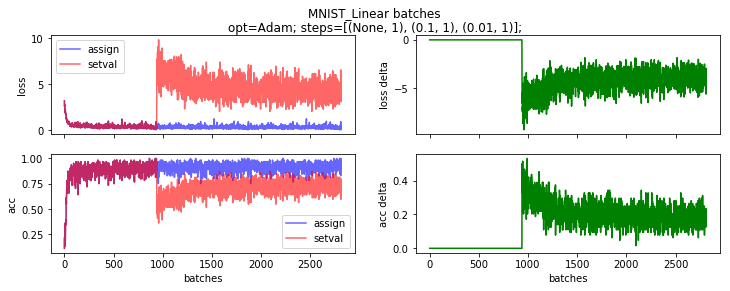

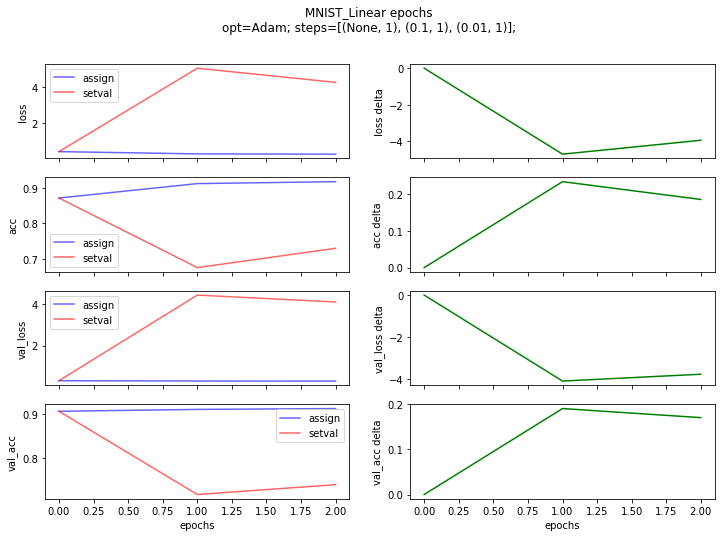

In [22]:
LRTester(MNIST_Linear).run(steps=[None, 0.1, 0.01]).makefigs()

Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.4333 - acc: 0.8726 - val_loss: 0.3210 - val_acc: 0.9059
Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.3100 - acc: 0.9122 - val_loss: 0.3082 - val_acc: 0.9111
Epoch 1/4
60000/60000 [==============================] - 24s - loss: 0.2959 - acc: 0.9172 - val_loss: 0.3052 - val_acc: 0.9124
Epoch 2/4
60000/60000 [==============================] - 24s - loss: 0.2884 - acc: 0.9197 - val_loss: 0.3041 - val_acc: 0.9136
Epoch 3/4
60000/60000 [==============================] - 24s - loss: 0.2833 - acc: 0.9212 - val_loss: 0.3033 - val_acc: 0.9138
Epoch 4/4
60000/60000 [==============================] - 30s - loss: 0.2796 - acc: 0.9226 - val_loss: 0.3031 - val_acc: 0.9147
Epoch 1/1
60000/60000 [==============================] - 32s - loss: 0.4333 - acc: 0.8726 - val_loss: 0.3210 - val_acc: 0.9059
Epoch 1/1
60000/60000 [==============================] - 25s - loss: 6.8714 - acc: 0.5677 - val_loss: 6.5073 - 

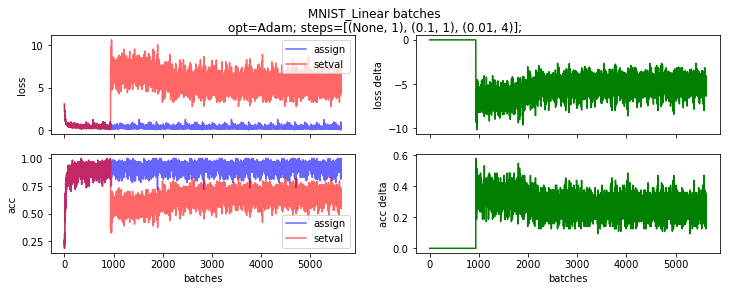

In [455]:
t = LRTester(MNIST_Linear, setter=AssignAndSetVal, optimizer=Adam)
t.run(steps=[(None, 1), (0.1, 1), (0.01, 4)])
t.makefig('batches')

In [456]:
t.save_state()

Epoch 1/1
60000/60000 [==============================] - 23s - loss: 0.4359 - acc: 0.8706 - val_loss: 0.3199 - val_acc: 0.9073
Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.3110 - acc: 0.9113 - val_loss: 0.3083 - val_acc: 0.9110
Epoch 1/1
60000/60000 [==============================] - 25s - loss: 0.2966 - acc: 0.9167 - val_loss: 0.3055 - val_acc: 0.9129
Epoch 1/1
60000/60000 [==============================] - 25s - loss: 0.4359 - acc: 0.8706 - val_loss: 0.3199 - val_acc: 0.9073
Epoch 1/1
60000/60000 [==============================] - 26s - loss: 4.7737 - acc: 0.6910 - val_loss: 4.6670 - val_acc: 0.7028
Epoch 1/1
60000/60000 [==============================] - 34s - loss: 4.2944 - acc: 0.7280 - val_loss: 4.1933 - val_acc: 0.7346


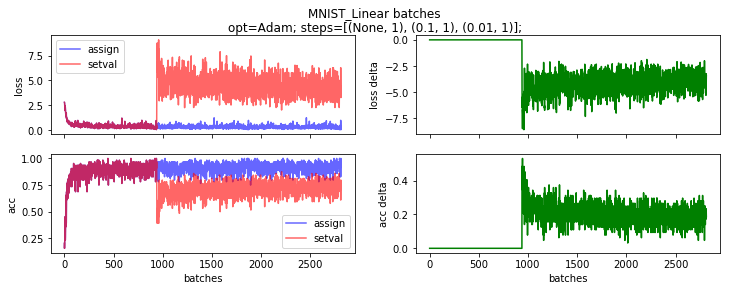

Epoch 1/1
60000/60000 [==============================] - 31s - loss: 0.4367 - acc: 0.8693 - val_loss: 0.3218 - val_acc: 0.9043
Epoch 1/1
60000/60000 [==============================] - 33s - loss: 5.7198 - acc: 0.6361 - val_loss: 5.4093 - val_acc: 0.6606
Epoch 1/1
60000/60000 [==============================] - 32s - loss: 5.3876 - acc: 0.6621 - val_loss: 5.2668 - val_acc: 0.6698
Epoch 1/1
60000/60000 [==============================] - 29s - loss: 0.4367 - acc: 0.8693 - val_loss: 0.3218 - val_acc: 0.9043
Epoch 1/1
60000/60000 [==============================] - 22s - loss: 5.7198 - acc: 0.6361 - val_loss: 5.4093 - val_acc: 0.6606.63 - ETA: 1s - l - ETA: 0s - loss: 5.7354 -  - ETA: 0s - los
Epoch 1/1
60000/60000 [==============================] - 32s - loss: 5.3876 - acc: 0.6621 - val_loss: 5.2668 - val_acc: 0.6698


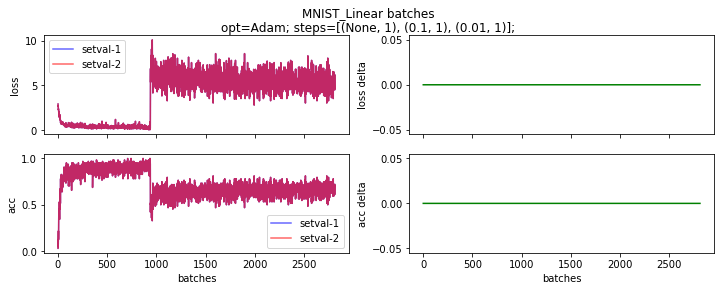

Epoch 1/1
60000/60000 [==============================] - 34s - loss: 0.4336 - acc: 0.8712 - val_loss: 0.3202 - val_acc: 0.9075
Epoch 1/1
60000/60000 [==============================] - 37s - loss: 0.3115 - acc: 0.9111 - val_loss: 0.3076 - val_acc: 0.9100
Epoch 1/1
60000/60000 [==============================] - 37s - loss: 0.2967 - acc: 0.9162 - val_loss: 0.3043 - val_acc: 0.9115
Epoch 1/1
60000/60000 [==============================] - 40s - loss: 0.4336 - acc: 0.8712 - val_loss: 0.3202 - val_acc: 0.9075
Epoch 1/1
60000/60000 [==============================] - 38s - loss: 0.3115 - acc: 0.9111 - val_loss: 0.3076 - val_acc: 0.9100
Epoch 1/1
60000/60000 [==============================] - 36s - loss: 0.2967 - acc: 0.9162 - val_loss: 0.3043 - val_acc: 0.9115


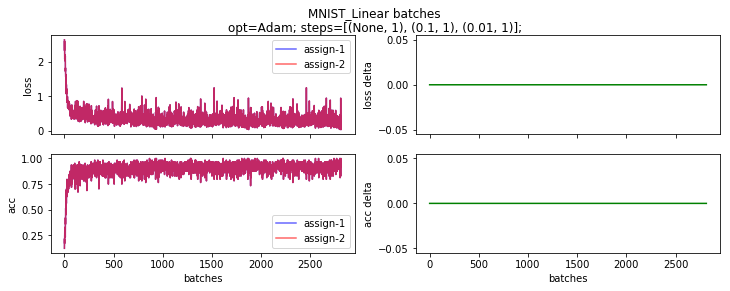

Epoch 1/1
60000/60000 [==============================] - 41s - loss: 0.5069 - acc: 0.8510 - val_loss: 0.3448 - val_acc: 0.90110.5072 - acc: 0.85
Epoch 1/1
60000/60000 [==============================] - 32s - loss: 0.3425 - acc: 0.9017 - val_loss: 0.3132 - val_acc: 0.9102
Epoch 1/1
60000/60000 [==============================] - 35s - loss: 0.3184 - acc: 0.9088 - val_loss: 0.3004 - val_acc: 0.9135
Epoch 1/1
60000/60000 [==============================] - 35s - loss: 0.5069 - acc: 0.8510 - val_loss: 0.3448 - val_acc: 0.9011
Epoch 1/1
60000/60000 [==============================] - 40s - loss: 0.3429 - acc: 0.9024 - val_loss: 0.3415 - val_acc: 0.9010
Epoch 1/1
60000/60000 [==============================] - 40s - loss: 0.2857 - acc: 0.9208 - val_loss: 0.2807 - val_acc: 0.9207


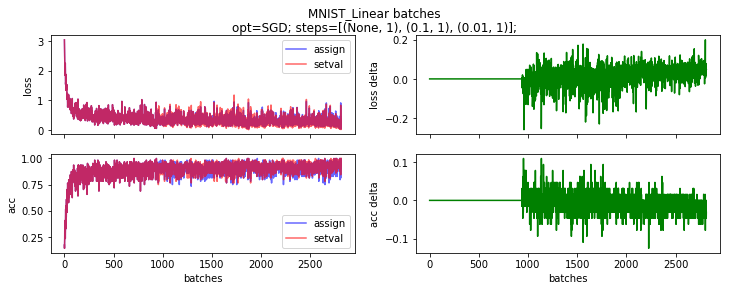

Epoch 1/1
60000/60000 [==============================] - 39s - loss: 0.5187 - acc: 0.8493 - val_loss: 0.3436 - val_acc: 0.9004
Epoch 1/1
60000/60000 [==============================] - 37s - loss: 0.3429 - acc: 0.9022 - val_loss: 0.3418 - val_acc: 0.9033
Epoch 1/1
60000/60000 [==============================] - 39s - loss: 0.2861 - acc: 0.9209 - val_loss: 0.2804 - val_acc: 0.9200.920 - ETA: 0s - loss: 0.
Epoch 1/1
60000/60000 [==============================] - 37s - loss: 0.5187 - acc: 0.8493 - val_loss: 0.3436 - val_acc: 0.9004
Epoch 1/1
60000/60000 [==============================] - 39s - loss: 0.3429 - acc: 0.9022 - val_loss: 0.3418 - val_acc: 0.9033
Epoch 1/1
60000/60000 [==============================] - 38s - loss: 0.2861 - acc: 0.9209 - val_loss: 0.2804 - val_acc: 0.9200


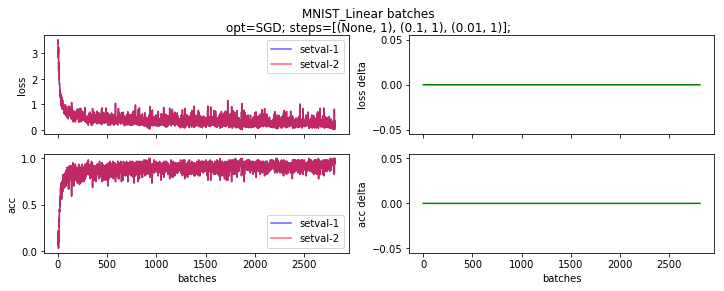

Epoch 1/1
60000/60000 [==============================] - 39s - loss: 0.5028 - acc: 0.8519 - val_loss: 0.3484 - val_acc: 0.8997
Epoch 1/1
60000/60000 [==============================] - 35s - loss: 0.3413 - acc: 0.9019 - val_loss: 0.3158 - val_acc: 0.9079
Epoch 1/1
60000/60000 [==============================] - 35s - loss: 0.3176 - acc: 0.9089 - val_loss: 0.3026 - val_acc: 0.9120
Epoch 1/1
60000/60000 [==============================] - 36s - loss: 0.5028 - acc: 0.8519 - val_loss: 0.3484 - val_acc: 0.8997
Epoch 1/1
60000/60000 [==============================] - 43s - loss: 0.3413 - acc: 0.9019 - val_loss: 0.3158 - val_acc: 0.9079
Epoch 1/1
60000/60000 [==============================] - 43s - loss: 0.3176 - acc: 0.9089 - val_loss: 0.3026 - val_acc: 0.9120


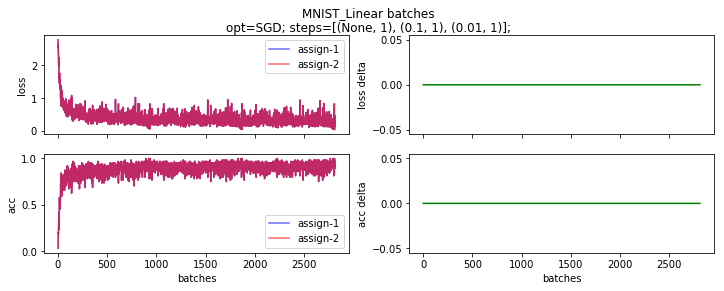

In [458]:
runtests(MNIST_Linear)

## MNIST CNN with batchnorm + dropout + data augmentation

In [118]:
class MNIST_CNN_BN(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        model = Sequential([
            Lambda(norm_input, input_shape=(1,28,28)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(32,3,3, activation='relu'),
            MaxPooling2D(),
            BatchNormalization(axis=1),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(64,3,3, activation='relu'),
            MaxPooling2D(),
            Flatten(),
            BatchNormalization(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(10, activation='softmax')
        ])
        model.compile(optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def _getbatches(cls, x=X_train, y=y_train, x_val=X_val, y_val=y_val, **kwargs):
        gen = image.ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                                       height_shift_range=0.08, zoom_range=0.08)
        batches = gen.flow(x, y, **kwargs)
        val_batches = gen.flow(x_val, y_val, **kwargs)
        return batches, val_batches
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        batch_size = kwargs.pop('batch_size', 64)
        shuffle = kwargs.pop('shuffle', False)
        batches, val_batches = cls._getbatches(batch_size=batch_size, shuffle=shuffle)
        model.fit_generator(batches, batches.N, validation_data=val_batches, nb_val_samples=val_batches.N,
                            **kwargs)

/home/ma/opt/anaconda3/envs/fastai/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/ma/opt/anaconda3/envs/fastai/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/ma/opt/anaconda3/envs/fastai/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


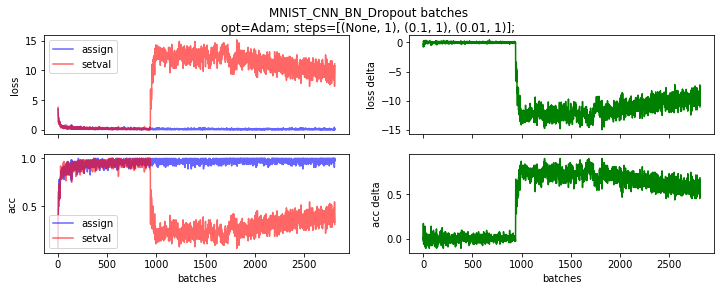

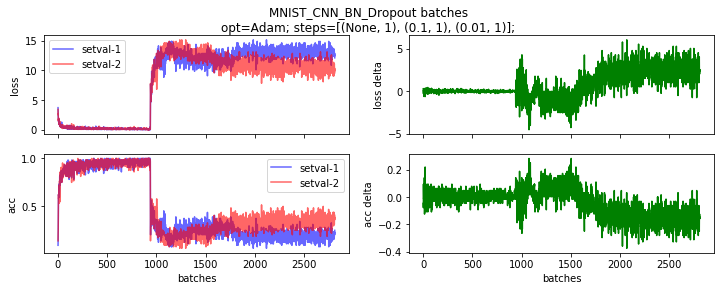

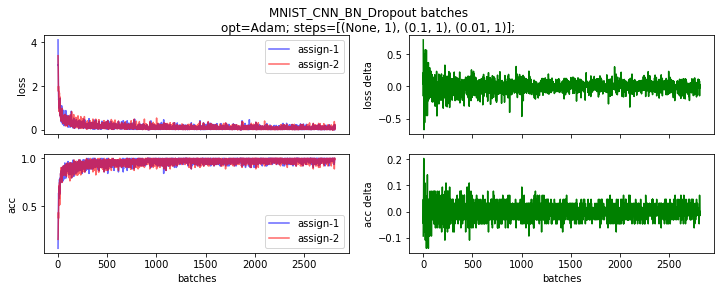

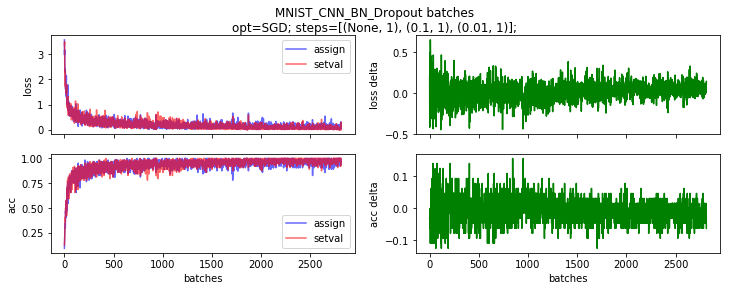

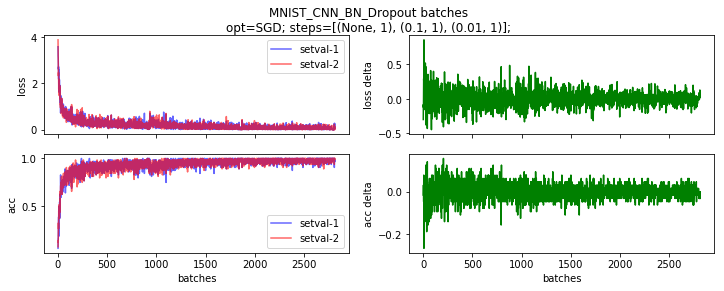

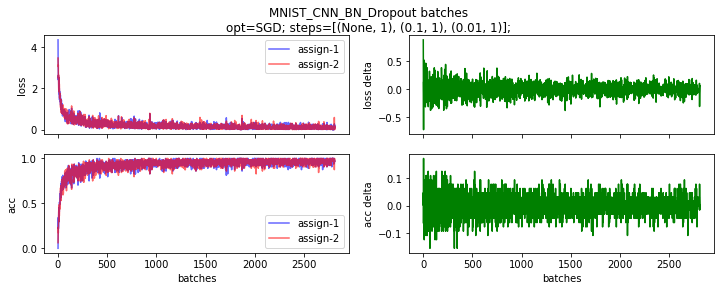

In [464]:
runtests(MNIST_CNN_BN)

## MNIST CNN with batchnorm, no dropout, no data augmentation

In [119]:
class MNIST_CNN_BN_NoDropout_NoDataAug(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        model = Sequential([
            Lambda(norm_input, input_shape=(1,28,28)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(32,3,3, activation='relu'),
            MaxPooling2D(),
            BatchNormalization(axis=1),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(64,3,3, activation='relu'),
            MaxPooling2D(),
            Flatten(),
            BatchNormalization(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.0),
            Dense(10, activation='softmax')
        ])
        model.compile(optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def _getbatches(cls, x=X_train, y=y_train, x_val=X_val, y_val=y_val, **kwargs):
        gen = image.ImageDataGenerator()
        batches = gen.flow(x, y, **kwargs)
        val_batches = gen.flow(x_val, y_val, **kwargs)
        return batches, val_batches
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        batch_size = kwargs.pop('batch_size', 64)
        shuffle = kwargs.pop('shuffle', False)
        batches, val_batches = cls._getbatches(batch_size=batch_size, shuffle=shuffle)
        model.fit_generator(batches, batches.N, validation_data=val_batches, nb_val_samples=val_batches.N,
                            **kwargs)

Epoch 1/1
60000/60000 [==============================] - 520s - loss: 0.0883 - acc: 0.9736 - val_loss: 0.0506 - val_acc: 0.9833
Epoch 1/1
60000/60000 [==============================] - 603s - loss: 0.0295 - acc: 0.9905 - val_loss: 0.0365 - val_acc: 0.9892
Epoch 1/1
60000/60000 [==============================] - 623s - loss: 0.0883 - acc: 0.9736 - val_loss: 0.0506 - val_acc: 0.9833
Epoch 1/1
60000/60000 [==============================] - 621s - loss: 11.1748 - acc: 0.3048 - val_loss: 10.9154 - val_acc: 0.3224


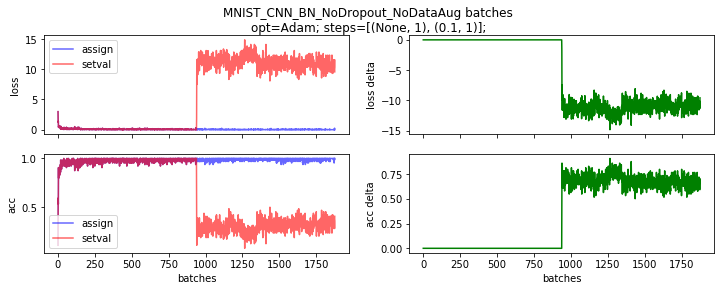

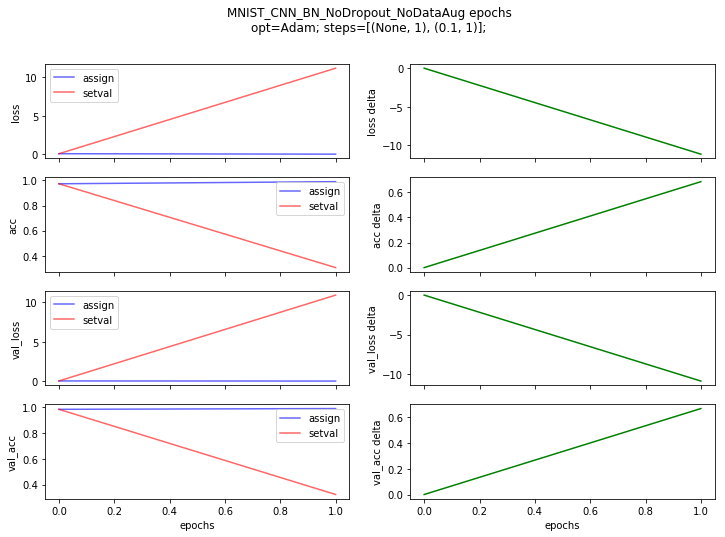

In [40]:
LRTester(MNIST_CNN_BN_NoDropout_NoDataAug).run([None, 0.1]).makefigs()

# Dogs and Cats

## Dogs and Cats Setup

In [107]:
dogscats_path = os.path.join(DATA_DIR, 'dogscats')
dogscats_train_path = os.path.join(dogscats_path, 'sample', 'train')
dogscats_valid_path = os.path.join(dogscats_path, 'sample', 'valid')

In [502]:
dogscats_zip = get_file('dogscats.zip', 'http://files.fast.ai/data/dogscats.zip',
                        cache_subdir=DATA_DIR, md5_hash='aef22ec7d472dd60e8ee79eecc19f131')
!unzip -q -d $DATA_DIR $dogscats_zip

In [108]:
def vgg_preprocess(x):
    # Use fully qualified vgg16.vgg_mean to avoid
    #   NameError: global name 'vgg_mean' is not defined
    # when attempting to load the vgg16 model via keras.models.load_model.
    # References:
    # https://github.com/fchollet/keras/issues/5298
    # https://github.com/fchollet/keras/issues/4079
    import vgg16
    x = x - vgg16.vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr

import vgg16
vgg16.vgg_preprocess = vgg_preprocess

## Dogs and Cats Vgg16

In [120]:
class DogsCats_Vgg16(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        vgg = Vgg16()
        vgg.model.compile(optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
        batches, _ = cls._getbatches(batch_size=64, shuffle=False)
        vgg.finetune(batches)
        return vgg.model
    
    @classmethod
    def _getbatches(cls, **kwargs):
        gen = image.ImageDataGenerator()
        kwargs['target_size'] = (224,224)
        kwargs['class_mode'] = 'categorical'
        batches = gen.flow_from_directory(dogscats_train_path, **kwargs)
        val_batches = gen.flow_from_directory(dogscats_valid_path, **kwargs)
        return batches, val_batches
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        batch_size = kwargs.pop('batch_size', 64)
        shuffle = kwargs.pop('shuffle', False)
        batches, val_batches = cls._getbatches(batch_size=batch_size, shuffle=shuffle)
        model.fit_generator(batches, batches.N, validation_data=val_batches, nb_val_samples=val_batches.N,
                            **kwargs)

Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.4305 - acc: 0.8727 - val_loss: 0.3216 - val_acc: 0.9039
Epoch 1/1
60000/60000 [==============================] - 25s - loss: 0.3099 - acc: 0.9116 - val_loss: 0.3102 - val_acc: 0.9097
Epoch 1/1
60000/60000 [==============================] - 26s - loss: 0.4305 - acc: 0.8727 - val_loss: 0.3216 - val_acc: 0.9039
Epoch 1/1
60000/60000 [==============================] - 27s - loss: 0.3099 - acc: 0.9116 - val_loss: 0.3102 - val_acc: 0.9097


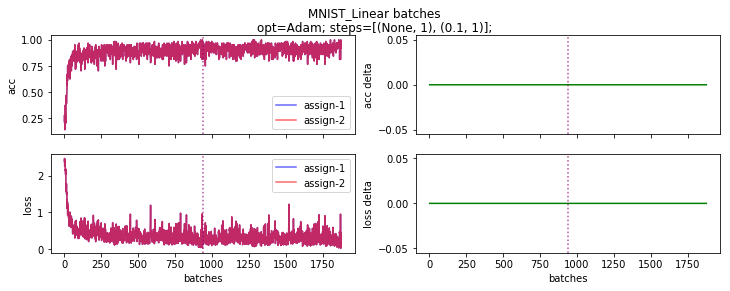

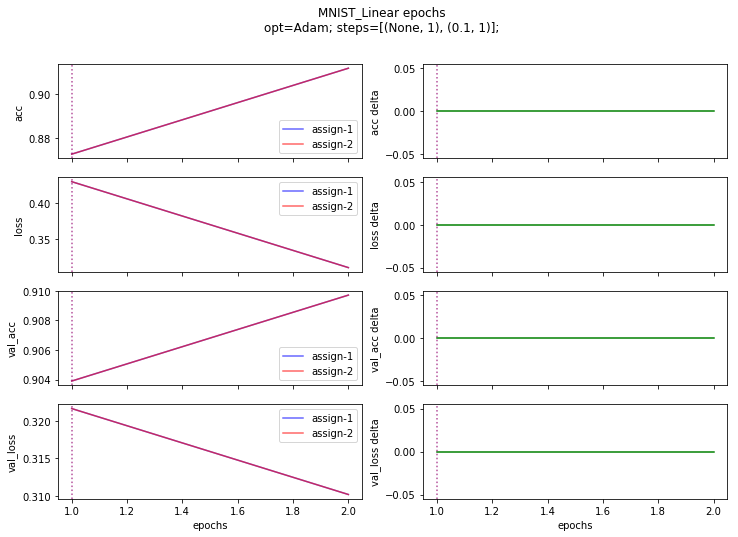

In [71]:
LRTester(MNIST_Linear, setter=BothAssign).run(steps=[None, 0.1]).makefigs()

## Dogs Cats Vgg16 No Dropout (Lesson 3)

# Lesson 4: IMDB Ratings

## IMDB Ratings Setup

In [110]:
movielens_path = os.path.join(DATA_DIR, 'ml-latest-small/')

In [ ]:
movielens_zip = get_file('ml-latest-small.zip',
                         'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip',
                         cache_subdir=DATA_DIR, md5_hash='be5b02baacd9e70dd97734ea0e19528a')
!unzip -q -d $DATA_DIR $movielens_zip

replace /home/ma/src/repos/fastai-courses/deeplearning1/nbs/data/lrtest/ml-latest-small/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [111]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [11]:
ml_ratings = pd.read_csv(movielens_path+'ratings.csv')
ml_movie_names = pd.read_csv(movielens_path+'movies.csv').set_index('movieId')['title'].to_dict()
ml_users = ml_ratings.userId.unique()
ml_movies = ml_ratings.movieId.unique()
ml_userid2idx = {o:i for i,o in enumerate(ml_users)}
ml_movieid2idx = {o:i for i,o in enumerate(ml_movies)}
ml_ratings.movieId = ml_ratings.movieId.apply(lambda x: ml_movieid2idx[x])
ml_ratings.userId = ml_ratings.userId.apply(lambda x: ml_userid2idx[x])
ml_n_users = ml_ratings.userId.nunique()
ml_n_movies = ml_ratings.movieId.nunique()
ml_n_factors = 50
np.random.seed = 42
msk = np.random.rand(len(ml_ratings)) < 0.8
ml_trn = ml_ratings[msk]
ml_val = ml_ratings[~msk]

## IMDB Ratings NN

In [116]:
class IMDB_Ratings(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        user_in, u = embedding_input('user_in', ml_n_users, ml_n_factors, 1e-4)
        movie_in, m = embedding_input('movie_in', ml_n_movies, ml_n_factors, 1e-4)
        x = merge([u, m], mode='concat')
        x = Flatten()(x)
        x = Dropout(0.3)(x)
        x = Dense(70, activation='relu')(x)
        x = Dropout(0.75)(x)
        x = Dense(1)(x)
        model = Model([user_in, movie_in], x)
        model.compile(optimizer=optimizer(), loss='mse', metrics=['accuracy'])
        return model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        model.fit([ml_trn.userId, ml_trn.movieId], ml_trn.rating,
                  validation_data=([ml_val.userId, ml_val.movieId], ml_val.rating),
                  **kwargs)

In [121]:
class IMDB_Ratings_NoDropout(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        user_in, u = embedding_input('user_in', ml_n_users, ml_n_factors, 1e-4)
        movie_in, m = embedding_input('movie_in', ml_n_movies, ml_n_factors, 1e-4)
        x = merge([u, m], mode='concat')
        x = Flatten()(x)
        x = Dropout(0.0)(x)
        x = Dense(70, activation='relu')(x)
        x = Dropout(0.0)(x)
        x = Dense(1)(x)
        model = Model([user_in, movie_in], x)
        model.compile(optimizer=optimizer(), loss='mse', metrics=['accuracy'])
        return model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        model.fit([ml_trn.userId, ml_trn.movieId], ml_trn.rating,
                  validation_data=([ml_val.userId, ml_val.movieId], ml_val.rating),
                  **kwargs)

Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 29s - loss: 2.5930 - acc: 0.1850 - val_loss: 1.2576 - val_acc: 0.2752
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 50s - loss: 1.5564 - acc: 0.2285 - val_loss: 0.8845 - val_acc: 0.3137
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 39s - loss: 1.2877 - acc: 0.2511 - val_loss: 0.8813 - val_acc: 0.2950
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 32s - loss: 2.6022 - acc: 0.1836 - val_loss: 1.2231 - val_acc: 0.2827
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 38s - loss: 6281.3644 - acc: 0.1915 - val_loss: 9091.3288 - val_acc: 0.2884
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 84

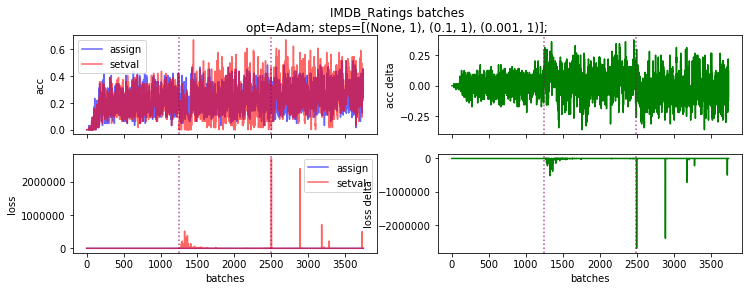

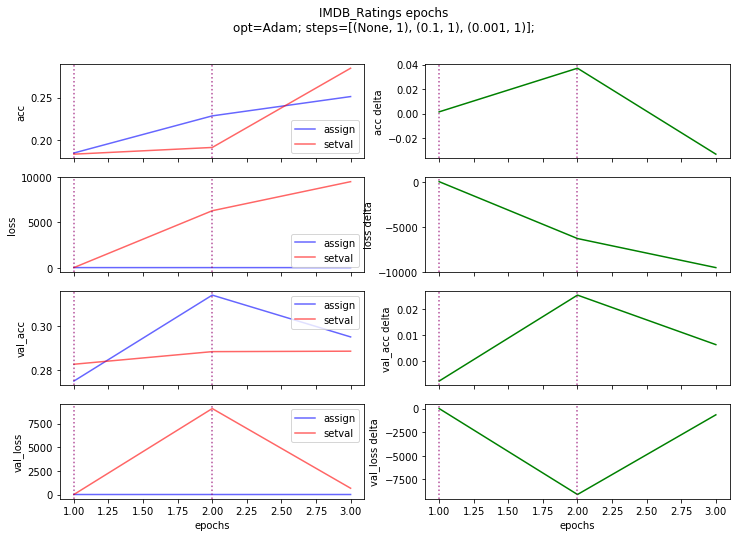

In [117]:
LRTester(IMDB_Ratings).run(steps=[None, 0.1, 0.001]).makefigs()

Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 25s - loss: 1.7542 - acc: 0.2605 - val_loss: 1.3941 - val_acc: 0.2633
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 32s - loss: 0.8565 - acc: 0.3217 - val_loss: 1.0303 - val_acc: 0.3119
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 30s - loss: 0.7941 - acc: 0.3357 - val_loss: 0.9269 - val_acc: 0.3213
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 24s - loss: 1.7542 - acc: 0.2605 - val_loss: 1.3941 - val_acc: 0.2633
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 33s - loss: 8276.0268 - acc: 0.2387 - val_loss: 6709.8118 - val_acc: 0.2771
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 56

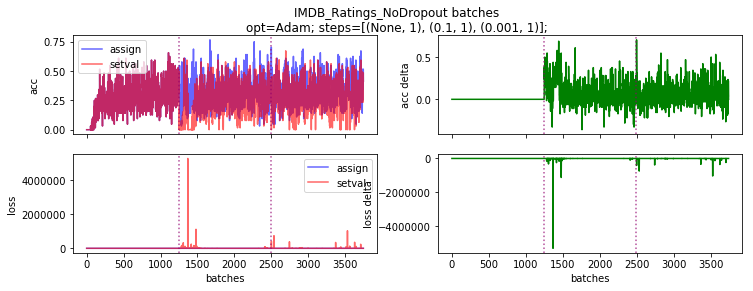

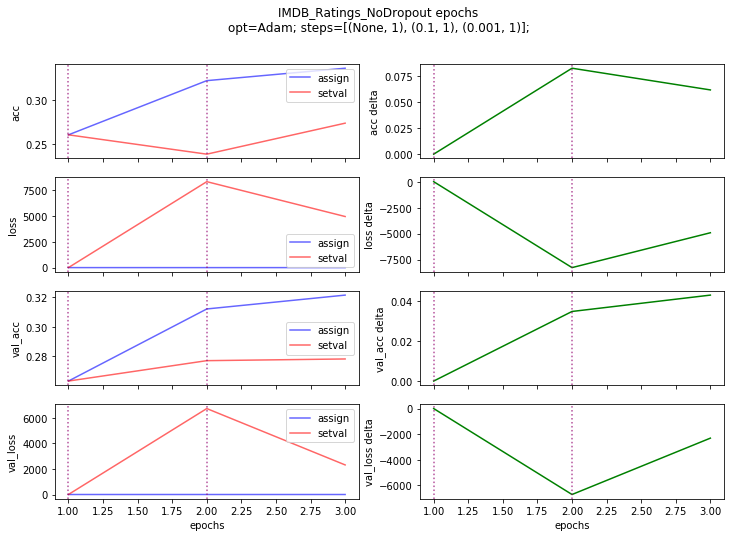

In [122]:
LRTester(IMDB_Ratings_NoDropout).run(steps=[None, 0.1, 0.001]).makefigs()

# Lesson 5: IMDB Sentiment Analysis

## IMDB Sentiment Analysis Setup

In [123]:
from keras.datasets import imdb
imdb_idx = imdb.get_word_index()
imdb_idx_arr = sorted(imdb_idx, key=imdb_idx.get)
imdb_idx2word = {v: k for k, v in imdb_idx.iteritems()}

In [124]:
imdb_path = get_file('imdb_full.pkl',
                     origin='https://s3.amazonaws.com/text-datasets/imdb_full.pkl',
                     cache_subdir=DATA_DIR, md5_hash='d091312047c43cf9e4e38fef92437263')

65536000/65552540 [============================>.] - ETA: 0s

In [134]:
glove_path = get_file('6B.50d',
                      origin='http://files.fast.ai/models/glove/6B.50d.tgz',
                      cache_subdir=DATA_DIR, md5_hash='8e1557d1228decbda7db6dfd81cd9909',
                      untar=True)

80109568/80107627 [==============================] - 133s   
Untaring file...


In [129]:
with open(imdb_path, 'rb') as f:
    (imdb_x_train, imdb_labels_train), (imdb_x_test, imdb_labels_test) = pickle.load(f)

imdb_vocab_size = 5000
imdb_trn = [np.array([i if i<imdb_vocab_size-1 else imdb_vocab_size-1 for i in s]) for s in imdb_x_train]
imdb_test = [np.array([i if i<imdb_vocab_size-1 else imdb_vocab_size-1 for i in s]) for s in imdb_x_test]

imdb_seq_len = 500
imdb_trn = sequence.pad_sequences(imdb_trn, maxlen=imdb_seq_len, value=0)
imdb_test = sequence.pad_sequences(imdb_test, maxlen=imdb_seq_len, value=0)

In [137]:
def glove_load_vectors(loc):
    return (load_array(loc+'.dat'),
        pickle.load(open(loc+'_words.pkl','rb')),
        pickle.load(open(loc+'_idx.pkl','rb')))

In [138]:
glove_vecs, glove_words, glove_wordidx = glove_load_vectors(glove_path)

In [139]:
def imdb_create_emb():
    n_fact = glove_vecs.shape[1]
    emb = np.zeros((imdb_vocab_size, n_fact))

    for i in range(1,len(emb)):
        word = imdb_idx2word[i]
        if word and re.match(r"^[a-zA-Z0-9\-]*$", word):
            src_idx = glove_wordidx[word]
            emb[i] = glove_vecs[src_idx]
        else:
            # If we can't find the word in glove, randomly initialize
            emb[i] = normal(scale=0.6, size=(n_fact,))

    # This is our "rare word" id - we want to randomly initialize
    emb[-1] = normal(scale=0.6, size=(n_fact,))
    emb/=3
    return emb

In [140]:
imdb_emb = imdb_create_emb()

## IMDB Sentiment Analysis CNN

In [141]:
class IMDB_Sentiment_Analysis(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        model = Sequential([
            Embedding(imdb_vocab_size, 50, input_length=imdb_seq_len, dropout=0.2, 
                      weights=[imdb_emb], trainable=False),
            Dropout(0.25),
            Convolution1D(64, 5, border_mode='same', activation='relu'),
            Dropout(0.25),
            MaxPooling1D(),
            Flatten(),
            Dense(100, activation='relu'),
            Dropout(0.7),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=optimizer(), loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        model.fit(imdb_trn, imdb_labels_train, validation_data=(imdb_test, imdb_labels_test), **kwargs)

In [143]:
class IMDB_Sentiment_Analysis_NoDropout(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        model = Sequential([
            Embedding(imdb_vocab_size, 50, input_length=imdb_seq_len, dropout=0.0,
                      weights=[imdb_emb], trainable=False),
            Dropout(0.0),
            Convolution1D(64, 5, border_mode='same', activation='relu'),
            Dropout(0.0),
            MaxPooling1D(),
            Flatten(),
            Dense(100, activation='relu'),
            Dropout(0.0),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=optimizer(), loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        model.fit(imdb_trn, imdb_labels_train, validation_data=(imdb_test, imdb_labels_test), **kwargs)

/home/ma/opt/anaconda3/envs/fastai/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/ma/opt/anaconda3/envs/fastai/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/ma/opt/anaconda3/envs/fastai/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 419s - loss: 0.4232 - acc: 0.9716 - val_loss: 7.0013 - val_acc: 0.5000
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 490s - loss: 1.0326 - acc: 0.4503 - val_loss: 0.7142 - val_acc: 0.5000
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 466s - loss: 0.4212 - acc: 0.9720 - val_loss: 7.6964 - val_acc: 0.5000
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 493s - loss: 4.5233 - acc: 0.5000 - val_loss: 1.2021 - val_acc: 0.5000


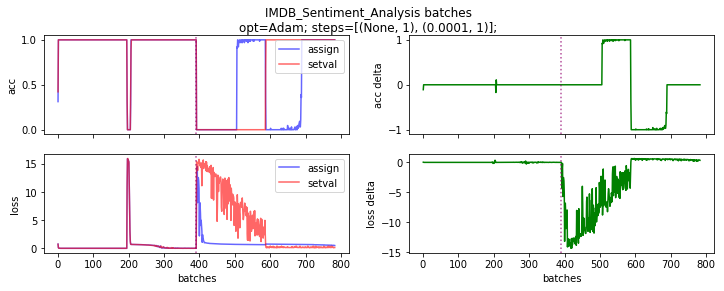

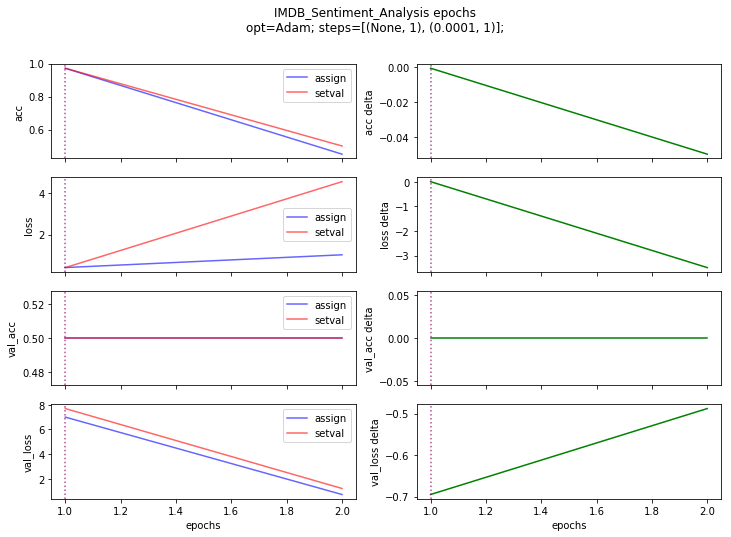

In [142]:
LRTester(IMDB_Sentiment_Analysis).run(steps=[None, 1e-4]).makefigs()

# Lesson 6: Nietzsche Postmodernism Generator RNN

# Lesson 7: Fisheries